In [1]:
import os
os.chdir('../')

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import torch

def get_cached_data(data_path):
    data = torch.load(data_path)
    
    image = data["image"]
    depth_gt = data["gt"].squeeze()
    depth_gt_sparse = data["dep"].squeeze()
    depth_pred = data["depth_pred"]
    
    return image, depth_gt, depth_gt_sparse, depth_pred

data_path = "/data2/wlsgur4011/SparseDC/datas/cache_prev/1.marigold(vanilla)_0f46ecad380de3e24d0689d19c70765b.pt"
image, depth_gt, depth_gt_sparse, depth_pred = get_cached_data(data_path)

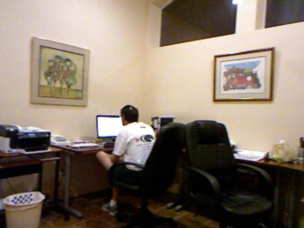

In [4]:
image

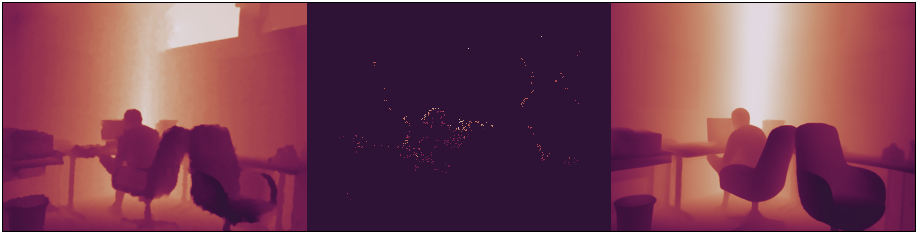

In [5]:
from jhutil import show_depth_all

show_depth_all(depth_gt, depth_gt_sparse, depth_pred)

In [6]:
from jhutil import show_depth
from src.utils.depth_utils import get_depth_sam_hull

depth_sam, hull_max = get_depth_sam_hull(image, depth_pred, depth_gt_sparse, lambda_param=100)
import jhutil; jhutil.jhprint(1111, (depth_sam - depth_gt).abs().mean())
(depth_sam - depth_gt).chans

[2024-02-23 11:51:17] [INFO] Created a temporary directory at /tmp/tmpgbf48l59
[2024-02-23 11:51:17] [INFO] Writing /tmp/tmpgbf48l59/_remote_module_non_scriptable.py
4444  "array[228, 304, 3] u8 n=207936 (0.2Mb) x∈[0, 255] μ=119.118 σ=86.397"
1111  "array[228, 304, 3] u8 n=207936 (0.2Mb) x∈[0, 255] μ=119.118 σ=86.397"
2222  "tensor[228, 304] n=69312 (0.3Mb) x∈[0., 1.000] μ=0.470 σ=0.244 cuda:0"
3333  "tensor[228, 304] n=69312 (0.3Mb) x∈[0., 4.365] μ=0.016 σ=0.223 cuda:0"


KeyboardInterrupt: 

1111  "tensor cuda:0 0.145"


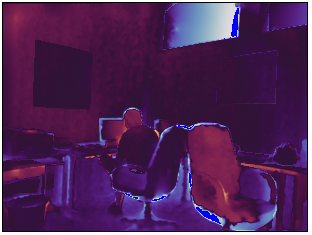

In [20]:
from jhutil import show_depth
from src.utils.depth_utils import get_depth_sam_shifted
from src.utils.depth_utils import *


sam = None
clusters = None


def get_depth_sam_shifted(rgb, depth_pred, depth_gt_sparse):
    device = depth_gt_sparse.device
    
    if isinstance(rgb, PIL.Image.Image):
        rgb = np.array(rgb)

    global sam, clusters
    if sam is None:
        sam_checkpoint = "/data2/wlsgur4011/SparseDC/pretrain/sam_vit_h_4b8939.pth"
        model_type = "vit_h"
        model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        model.to(device="cuda")
        sam = SamAutomaticMaskGenerator(model)
    clusters = sam.generate(rgb)
    global_scale, global_shift = compute_scale_and_shift(depth_pred, depth_gt_sparse, mask=(depth_gt_sparse != 0))
    depth_affine = global_scale * depth_pred + global_shift
    
    depth_shifted = torch.zeros_like(depth_affine)
    depth_count = torch.zeros_like(depth_shifted)

    for i, cluster in enumerate(clusters):
        cluster = torch.tensor(cluster['segmentation'], device=device)
        cluster_depth = cluster * depth_gt_sparse

        mask = cluster_depth != 0
        n_points = mask.sum()
        if n_points == 0:
            continue
        
        points_pred = depth_affine[mask]
        points_gt = cluster_depth[mask]
        local_shift = (points_gt - points_pred).mean()
        
        depth_shifted[cluster] += n_points * (depth_affine[cluster] + local_shift)
        depth_count[cluster] += n_points
    
    mask = depth_count != 0
    depth_shifted[mask] /= depth_count[mask]
    depth_shifted[~mask] = depth_affine[~mask]
    
    return depth_shifted


depth_shifted = get_depth_sam_shifted(image, depth_pred, depth_gt_sparse)
import jhutil; jhutil.jhprint(1111, (depth_shifted - depth_gt).abs().mean())
(depth_shifted - depth_gt).chans

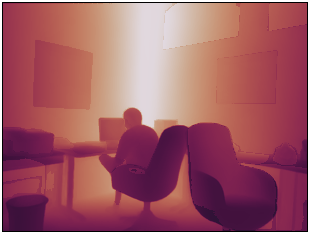

In [19]:
depth_shifted - depth

1111  "tensor[228, 304] n=69312 (0.3Mb) x∈[-10.000, 1.000] μ=0.094 σ=0.813 cuda:0"
1111  "tensor cuda:0 0.005"
2222  "tensor cuda:0 0.019"


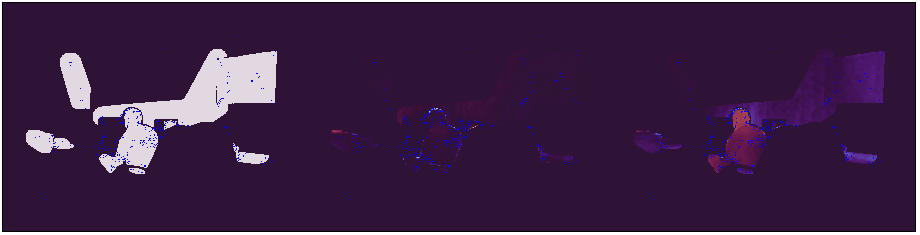

In [7]:
def compare_sam_and_affine(image, depth_pred, depth_gt_sparse):
    mask_sparse = depth_gt_sparse != 0
    
    depth_sam, sam_mask = get_depth_sam_hull(image, depth_pred, depth_gt_sparse)
    depth_affine = get_depth_affine(depth_pred, depth_gt_sparse)
    
    diff_sam = (depth_sam - depth_gt) * sam_mask
    diff_affine = (depth_affine - depth_gt) * sam_mask
    
    err_sam = diff_sam.abs().mean()
    err_affine = diff_affine.abs().mean()
    sam_mask = sam_mask.float()
    sam_mask[depth_gt_sparse != 0] = -10
    import jhutil; jhutil.jhprint(1111, sam_mask)
    diff_sam[depth_gt_sparse != 0] = -10
    diff_affine[depth_gt_sparse != 0] = -10
    visualization = torch.concat([sam_mask, diff_sam, diff_affine], dim=1).chans
    
    return err_sam, err_affine, visualization

err_sam, err_affine, visualization = compare_sam_and_affine(image, depth_pred, depth_gt_sparse)

import jhutil; jhutil.jhprint(1111, err_sam)
import jhutil; jhutil.jhprint(2222, err_affine)
visualization

In [37]:
import numpy as np
data_folder = "/data2/wlsgur4011/SparseDC/datas/cache"
data_path_iter = iter(os.listdir(data_folder))

In [81]:
while True:
    data_path = os.path.join(data_folder, next(data_path_iter))
    image, depth_gt, depth_gt_sparse, depth_pred = get_cached_data(data_path)
    err_sam, err_affine, visualization = compare_sam_and_affine(image, depth_pred, depth_gt_sparse)
    import jhutil; jhutil.jhprint(1111, err_sam)
    import jhutil; jhutil.jhprint(2222, err_affine)
    break
visualization

1111  "tensor[1] cuda:0 [3.124]" "tensor[1] cuda:0 [2.868]"
1111  "tensor[1] cuda:0 [2.418]" "tensor[1] cuda:0 [2.868]"
1111  "tensor[1] cuda:0 [2.807]" "tensor[1] cuda:0 [2.868]"
1111  "tensor[1] cuda:0 [1.007]" "tensor[1] cuda:0 [2.868]"


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1839743913  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 1.2e-13  _one-merge 5.8e-13
  _near-inside 2.9e-12  Visible-distance 2.3e-13  U-max-coplanar 2.3e-13
  Width-outside 4.6e-13  _wide-facet 1.4e-12  _maxoutside 7e-13

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):    52 1.4e+02
- p3(v2):    54 1.4e+02
- p0(v1):    51 1.3e+02

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.2e-13.  The center point, facets and distances
to the center point are as follows:

center point    52.33    135.3

facet p3 p0 distance= 1.4e-14
facet p1 p0 distance= -1.4e-14
facet p1 p3 distance= -1.4e-14

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:        51        54  difference=    3
  1:       134       137  difference=    3

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 1.2e-13.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


1111  "tensor[1] cuda:0 [3.124]" "tensor[1] cuda:0 [2.868]"
1111  "tensor[1] cuda:0 [2.418]" "tensor[1] cuda:0 [2.868]"
1111  "tensor[1] cuda:0 [2.807]" "tensor[1] cuda:0 [2.868]"
1111  "tensor[1] cuda:0 [1.007]" "tensor[1] cuda:0 [2.868]"


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1840466614  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 1.2e-13  _one-merge 5.8e-13
  _near-inside 2.9e-12  Visible-distance 2.3e-13  U-max-coplanar 2.3e-13
  Width-outside 4.6e-13  _wide-facet 1.4e-12  _maxoutside 7e-13

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):    52 1.4e+02
- p3(v2):    54 1.4e+02
- p0(v1):    51 1.3e+02

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.2e-13.  The center point, facets and distances
to the center point are as follows:

center point    52.33    135.3

facet p3 p0 distance= 1.4e-14
facet p1 p0 distance= -1.4e-14
facet p1 p3 distance= -1.4e-14

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:        51        54  difference=    3
  1:       134       137  difference=    3

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 1.2e-13.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


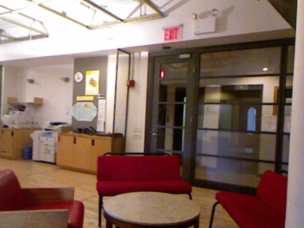

In [61]:
image

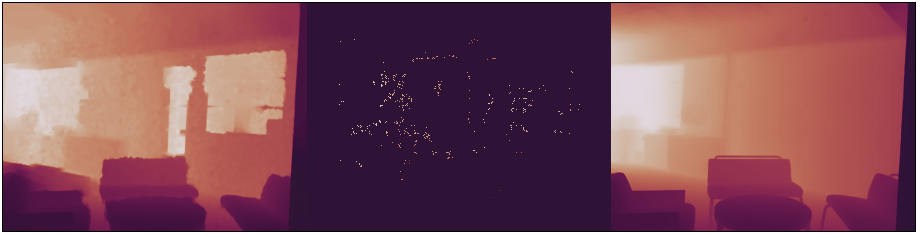

In [60]:
from jhutil import show_depth_all
show_depth_all(depth_gt, depth_gt_sparse, depth_pred)